In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import math
df = pd.read_csv('airline-passengers.csv',
                 parse_dates=['Month'],
                 index_col='Month')
#df.rename(columns={'#Passengers': 'Passengers'}, inplace=True) # Переименуем для удобства
print(df.head())
print(df.info)
print(df.describe().T)

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
<bound method DataFrame.info of             Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]>
            count        mean         std    min    25%    50%    75%    max
Passengers  144.0  280.298611  119.966317  104.0  180.0  265.5  360.5  622.0


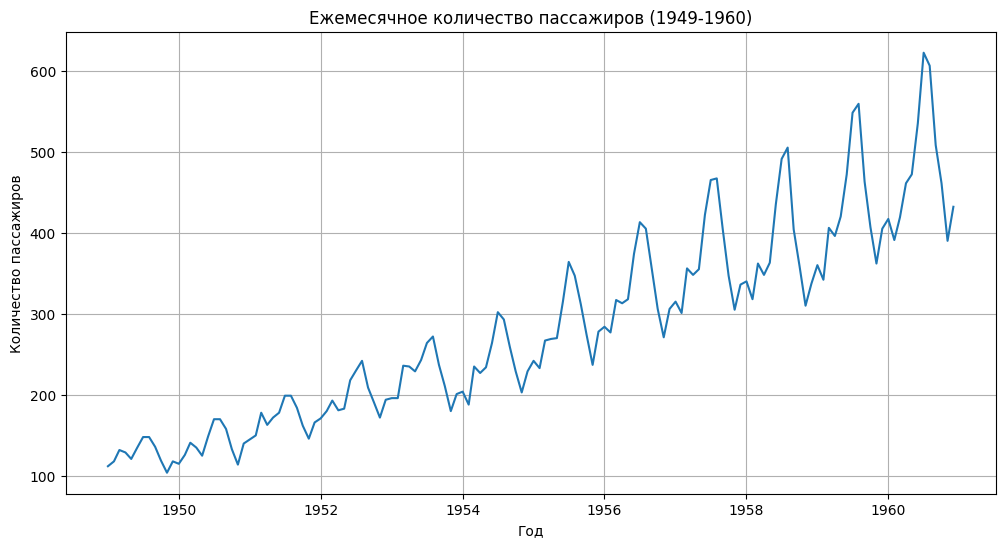

In [2]:
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'])
plt.title('Ежемесячное количество пассажиров (1949-1960)')
plt.xlabel('Год')
plt.ylabel('Количество пассажиров')
plt.grid(True)
plt.show()

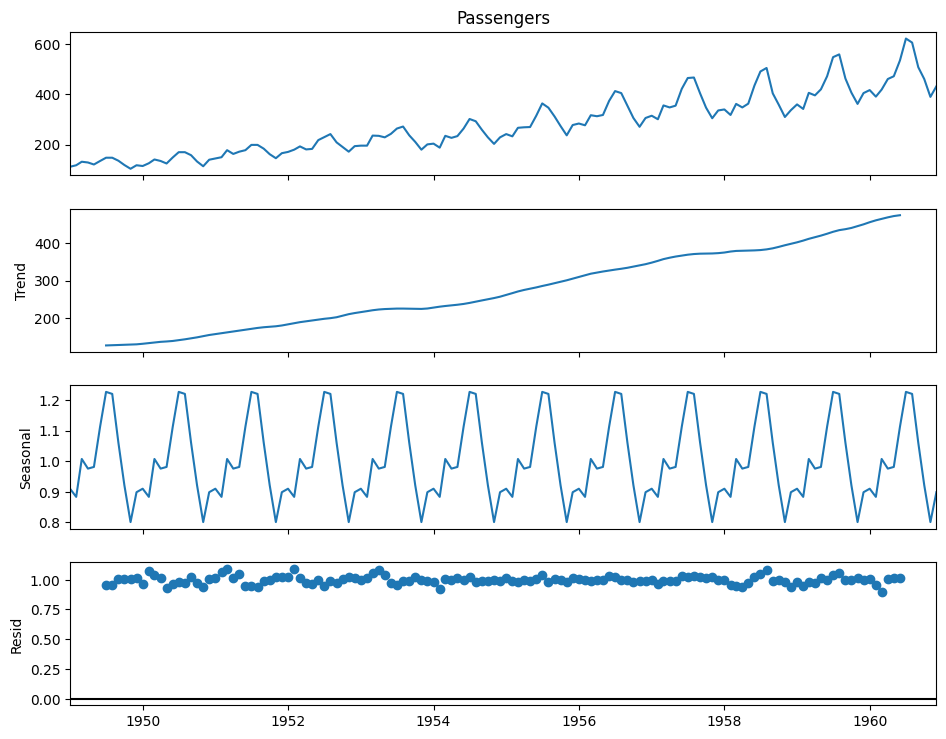

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Passengers'], model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.show()

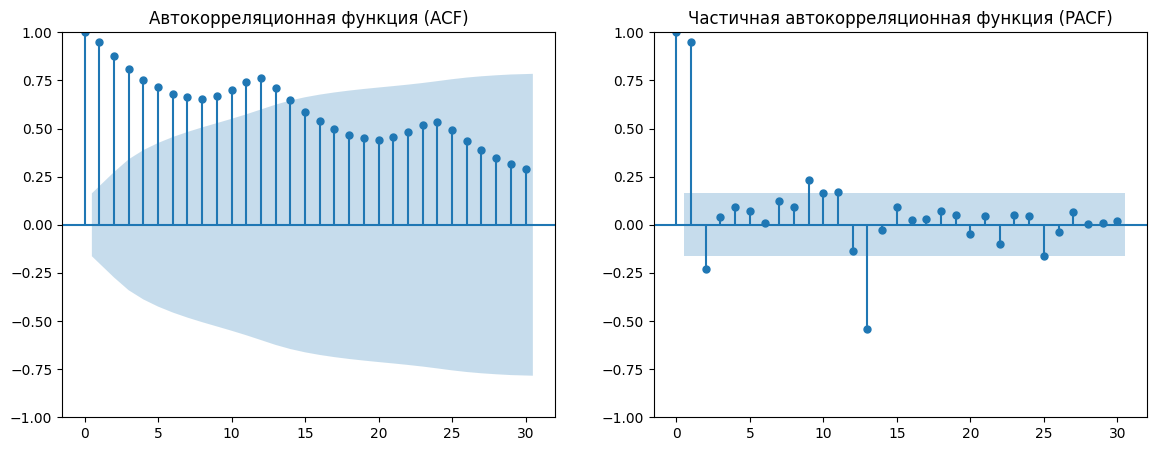

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['Passengers'], lags=30, ax=ax[0])
ax[0].set_title('Автокорреляционная функция (ACF)')
plot_pacf(df['Passengers'], lags=30, ax=ax[1])
ax[1].set_title('Частичная автокорреляционная функция (PACF)')
plt.show()

In [5]:
# 3. Разбиение
test_size = 24
train_data = df[:-test_size]
test_data = df[-test_size:]

In [6]:
# 4.
results = {}
# 4.1
from statsmodels.tsa.statespace.sarimax import SARIMAX
# (p,d,q) = (2,1,1) - несезонная часть
# (P,D,Q,m) = (1,1,0,12) - сезонная часть
sarima_model = SARIMAX(train_data['Passengers'],
                       order=(2, 1, 1),
                       seasonal_order=(1, 1, 0, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)
# Прогноз
sarima_pred = sarima_fit.predict(start=test_data.index[0], end=test_data.index[-1])
results['SARIMA'] = sarima_pred

C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [7]:
# 4.2. Символьная регрессия
from gplearn.genetic import SymbolicRegressor
from sklearn.preprocessing import StandardScaler

# Подготовка данных: создание лаговых признаков
def create_lagged_features(series, n_lags):
    df_lags = pd.DataFrame(index=series.index)
    for i in range(1, n_lags + 1):
        df_lags[f'lag_{i}'] = series.shift(i)
    df_lags['target'] = series
    df_lags.dropna(inplace=True)
    return df_lags.drop('target', axis=1), df_lags['target']

n_lags_sr = 5
X_train_sr, y_train_sr = create_lagged_features(train_data['Passengers'], n_lags_sr)
scaler_sr = StandardScaler()
X_train_sr_scaled = scaler_sr.fit_transform(X_train_sr)


sr_model = SymbolicRegressor(population_size=2000,
                             generations=20,
                             stopping_criteria=0.01,
                             p_crossover=0.7, p_subtree_mutation=0.1,
                             p_hoist_mutation=0.05, p_point_mutation=0.1,
                             max_samples=0.9, verbose=0,
                             parsimony_coefficient=0.01,
                             random_state=42,
                             n_jobs=-1,
                             function_set=('add', 'sub', 'mul', 'div', 'sqrt', 'log', 'sin', 'cos', 'tan'))


sr_model.fit(X_train_sr_scaled, y_train_sr)
print(f"Лучшая формула Symbolic Regression: {sr_model._program}")
history = train_data['Passengers'].values[-n_lags_sr:].tolist()
sr_pred_list = []

for t in range(len(test_data)):
    current_lags = np.array(history[-n_lags_sr:]).reshape(1, -1)
    current_lags_scaled = scaler_sr.transform(current_lags)
    next_pred = sr_model.predict(current_lags_scaled)[0]
    sr_pred_list.append(next_pred)
    history.append(next_pred)

sr_pred = pd.Series(sr_pred_list, index=test_data.index)
results['Symbolic Regression'] = sr_pred

C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Лучшая формула Symbolic Regression: add(div(add(log(tan(sub(X1, tan(sin(cos(X1)))))), log(tan(tan(log(cos(-0.093)))))), log(cos(tan(tan(cos(log(log(cos(0.108))))))))), sub(tan(sub(X1, tan(log(div(X4, X4))))), div(tan(sqrt(cos(cos(sqrt(sub(-0.734, X1)))))), log(cos(0.108)))))


C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\envs\py310_gmdh\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fit

In [16]:
# 4.3: GMDH (MULTI и MIA/RIA)
from gmdh import Multi, Ria, Mia, time_series_transformation

n_lags_gmdh = 12

X_train_gmdh, y_train_gmdh = time_series_transformation(train_data['Passengers'].values, lags=n_lags_gmdh)

# 4.3.1. MULTI
multi_model = Multi()
multi_model.fit(X_train_gmdh, y_train_gmdh, n_jobs=-1, verbose=0)
print(f"Лучший полином MULTI: {multi_model.get_best_polynomial()}")

# MULTI
history_multi = train_data['Passengers'].values[-n_lags_gmdh:].tolist()
multi_pred_list = []
for t in range(len(test_data)):
    current_lags_multi = np.array(history_multi[-n_lags_gmdh:]).reshape(1, -1)
    next_pred_multi = multi_model.predict(current_lags_multi)[0]
    multi_pred_list.append(next_pred_multi)
    history_multi.append(next_pred_multi)

multi_pred = pd.Series(multi_pred_list, index=test_data.index)
results['GMDH_MULTI'] = multi_pred


#  4.3.2. RIA
ria_model = Ria()
ria_model.fit(X_train_gmdh, y_train_gmdh, n_jobs=-1, verbose=0)
print(f"Лучший полином RIA: {ria_model.get_best_polynomial()}")

# Прогноз MIA
history_ria = train_data['Passengers'].values[-n_lags_gmdh:].tolist()
ria_pred_list = []
for t in range(len(test_data)):
    current_lags_ria = np.array(history_ria[-n_lags_gmdh:]).reshape(1, -1)
    next_pred_ria = ria_model.predict(current_lags_ria)[0]
    ria_pred_list.append(next_pred_ria)
    history_ria.append(next_pred_ria) 

ria_pred = pd.Series(ria_pred_list, index=test_data.index)
results['GMDH_RIA'] = ria_pred

Лучший полином MULTI: y = 0.6389*x1 + 0.1583*x2 - 0.1069*x3 - 0.0734*x11 + 0.3996*x12 + 13.064
Лучший полином RIA: f1 = 0.5695*x3 + 0.633*x12 - 0.0012*x3*x12 - 0.0001*x3^2 + 0.0007*x12^2 - 8.252
y = - 0.0423*x3 + 1.042*f1 + 0.0006*x3*f1 - 0.0002*x3^2 - 0.0004*f1^2 - 0.4102


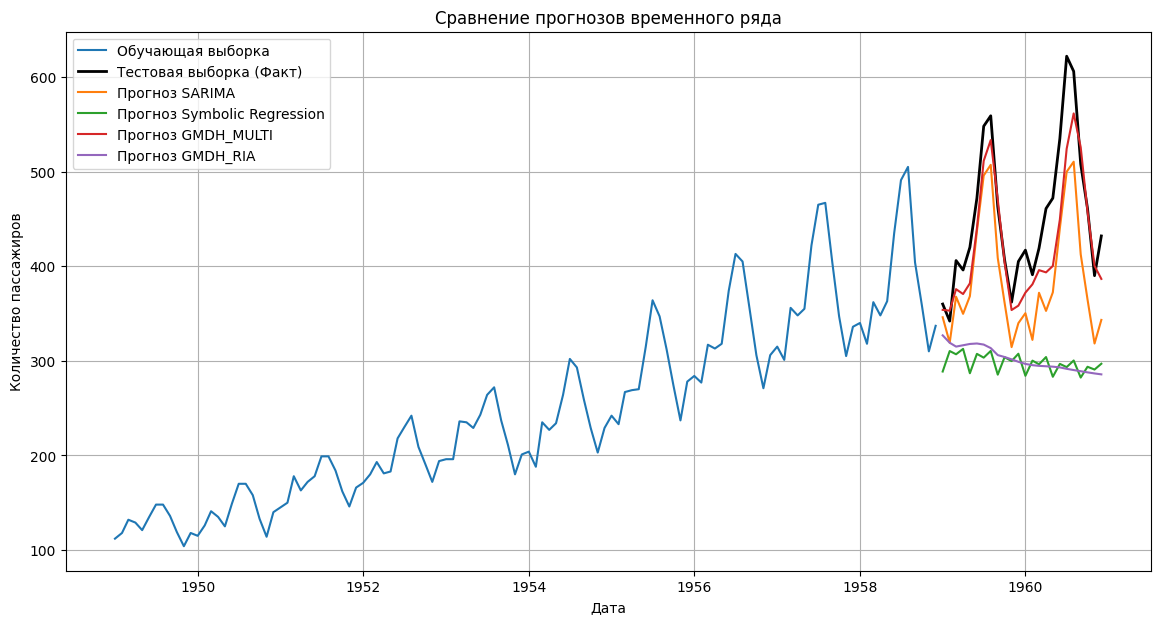

In [18]:
# 4.4: Визуализация
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['Passengers'], label='Обучающая выборка')
plt.plot(test_data.index, test_data['Passengers'], label='Тестовая выборка (Факт)', color='black', linewidth=2)

for name, result_data in results.items():
    if result_data is not None:
        plt.plot(result_data.index, result_data, label=f'Прогноз {name}')

plt.title('Сравнение прогнозов временного ряда')
plt.xlabel('Дата')
plt.ylabel('Количество пассажиров')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# 4.5: Оценка качества прогнозов
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

metrics_results = {}
actual_values = test_data['Passengers']

for name, result_data in results.items():
    pred_values = result_data
    mae = mean_absolute_error(actual_values, pred_values)
    mse = mean_squared_error(actual_values, pred_values)
    rmse = math.sqrt(mse)
    try:
        r2 = r2_score(actual_values, pred_values)
    except ValueError: # Если все предсказания одинаковые
        r2 = np.nan

    metrics_results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2
    }

# Сравнение результатов
metrics_df = pd.DataFrame(metrics_results).T
metrics_df = metrics_df[['MAE', 'MSE', 'RMSE', 'R^2']]
print(metrics_df.round(4))

                          MAE         MSE      RMSE     R^2
SARIMA                65.8014   5106.6492   71.4608  0.0843
Symbolic Regression  154.5490  29642.4825  172.1699 -4.3154
GMDH_MULTI            33.0055   1759.9576   41.9518  0.6844
GMDH_RIA             150.0120  28754.1181  169.5704 -4.1561
